In [2]:
import zipfile
import sys, re
from os import listdir
from os.path import isfile, isdir, join
import os

import numpy as np
from matplotlib import pyplot as plt
import skimage as sk
import skimage.transform as transform
import skimage.io as skio
from skimage import color
import random
import seaborn as sns
import xml.etree.ElementTree as ET 
import pandas as pd

import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models

1.7.0+cu101


# PART1: Nose Tip Detection

## Buid Classifier

In [7]:
with zipfile.ZipFile('imm_face_db.zip', 'r') as zip_ref:
    zip_ref.extractall('imm_face_db')

In [8]:
folder = "imm_face_db"
asf = [join(folder, f) for f in listdir(folder) if ".asf" in join(folder, f)]
imgs = [skio.imread(asf[i][:-3] + "jpg") for i in range(len(asf))]

In [ ]:
def extract_points(x_length, y_length):
  landmarks = []
  nose_keypoint = []
  for i in range(len(asf)):
      file = open(asf[i], "r")
      landmark = []
      points = file.readlines()[16:74]
      for point in points:
        x,y = point.split('\t')[2:4]
        landmark.append([float(x) * y_length, float(y) * x_length])
      landmarks.append(np.array(landmark))
      nose_keypoint.append(np.array(landmark[-6]))
  return landmarks, nose_keypoint 

In [ ]:
landmarks, nose_keypoint = extract_points(60, 80)
BATCH_SIZE = 1

In [ ]:
class FaceLandmarksDataset(Dataset):
  """Face Landmarks dataset."""

  def __init__(self, imgs, all_landmarks, transform=None):
    """
    Args:
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    self.imgs = imgs
    self.landmarks = all_landmarks

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()


    image = self.imgs[idx]
    landmark = self.landmarks[idx]
    landmark = landmark.astype(np.float32)#.reshape(-1, 2)
    sample = {'image': image, 'landmarks': landmark}

    if self.transform:
        sample['image'] = self.transform(sample['image'])


    return sample

In [ ]:
nose_train_dataset = FaceLandmarksDataset(imgs[:192], nose_keypoint[:192], transform=transforms.Compose(
                  [transforms.ToPILImage(), 
                  transforms.Resize((60, 80)), 
                  transforms.Grayscale(num_output_channels=1),
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.5], std=[0.5])]))
nose_val_dataset = FaceLandmarksDataset(imgs[192:], nose_keypoint[192:], transform=transforms.Compose(
                  [transforms.ToPILImage(), 
                  transforms.Resize((60, 80)),
                  transforms.Grayscale(num_output_channels=1), 
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.5], std=[0.5]),]))
train_nose_dataloader = DataLoader(nose_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_nose_dataloader = DataLoader(nose_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [1]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    for i in range(batch_size):
      plt.figure()
      plt.imshow(images_batch[i,0, :, :], cmap="gray")
      plt.axis('off')
      plt.scatter(landmarks_batch[i, :, 0].numpy(),
                    landmarks_batch[i, :, 1].numpy(),
                    s=40, marker='.', c='r')

      plt.savefig("dataloader3_" + str(i) + ".jpg")
      if(i > 4):
        break



In [ ]:
for i_batch, sample_batched in enumerate(train_nose_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
      show_landmarks_batch(sample_batched)
      break

## Build CNN

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 12, 7)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.conv3 = nn.Conv2d(24, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(896, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


    def run_training(self, train_loader, val_loader, lr=1e-3, num_epochs=25):

      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(self.parameters(), lr=lr)
      training_loss = []
      validation_loss = []

      print("***START TRAINING***")
      for epoch in range(num_epochs):
        self.train()
        epoch_loss = 0
        running_loss = 0

        for i, data in enumerate(train_loader, 0):
          image, landm = data['image'].float(), data['landmarks'].float()
          # change image from [4, 60, 80] to [4, 1, 60, 80]
          # image = image.unsqueeze(1)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = self(image)
          # outputs = outputs.unsqueeze(1)
          # outputs = outputs.view(1, 1, -1)
          # print(landm.shape)
          loss = loss_function(outputs, landm)
          loss.backward()
          optimizer.step()
      
          # print statistics
          epoch_loss += loss.item()
          running_loss += loss.item()

          if i % 30 == 29:    # print every 30 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0

        print(epoch+1, epoch_loss / len(train_loader) / BATCH_SIZE)
        val_loss = self.evaluate(val_loader)
        training_loss.append(epoch_loss /len(train_loader))
        validation_loss.append(val_loss)

      print("FINISHED TRAINING")
      predictions = []
      for i, data in enumerate(val_loader, 0):
        image, landm = data['image'].float(), data['landmarks'].float()
        outputs = self(image)#.unsqueeze(1))
        predictions.append({"image": image, "landmark": landm, "pred": outputs})
      return predictions, training_loss, validation_loss



    def evaluate(self, val_loader):
      val_loss = 0
      loss_function = nn.MSELoss()
      for i, data in enumerate(val_loader, 0):
        image, landm = data['image'].float(), data['landmarks'].float()
        outputs = self(image)#.unsqueeze(1))
        loss = loss_function(outputs, landm)
        val_loss += loss.item()
      
      return val_loss / len(val_loader)



In [ ]:
net = NeuralNet()
print(net)

In [ ]:
NUM_EPOCH = 25
LEARNING_RATE = 1e-4
predictions, training_loss, validation_loss = net.run_training(train_nose_dataloader, val_nose_dataloader,LEARNING_RATE, NUM_EPOCH)

In [ ]:
plt.plot(training_loss, label="training_loss")
plt.plot(validation_loss, label="validation_loss")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();
plt.savefig("training_plot.jpg")

In [ ]:
for i, data in enumerate(val_nose_dataloader, 0):
  image, landm = data['image'].float(), data['landmarks'].float()
  outputs = net(image)#.unsqueeze(1))
  print(outputs)
  plt.figure()
  plt.imshow(image[0,:,:].squeeze(0).detach().numpy(), cmap='gray')
  plt.axis('off')
  plt.scatter(landm.numpy()[0][0][0],landm.numpy()[0][0][1], s=40, marker='.', c='r')
  plt.scatter(outputs.detach().numpy()[0][0],outputs.detach().numpy()[0][1], s=40, marker='.', c='g')
  plt.savefig("training_nose_" + str(i) + ".jpg")
  if i == 3:
    break

# PART2: Full Facial Keypoint Detection

## Prepare Dataloader

In [ ]:
imgs = [color.rgb2gray(skio.imread(asf[i][:-3] + "jpg")) for i in range(len(asf))]
landmarks, nose_keypoint = extract_points(480, 640)
BATCH_SIZE = 1

In [5]:
def rotate_image(imgs, landmarks):
  degrees = [-15, -10, -5, 5, 10, 15]
  random.seed(194)
  rotate_imgs = []
  rotate_landmarks = []
  for i in range(len(imgs)):
    deg = random.choice(degrees)
    rotate_imgs.append(sk.transform.rotate(imgs[i], deg).astype(np.float32))

    c, s = np.cos(np.radians(-deg)), np.sin(np.radians(-deg))
    R = np.array(((c, -s), (s, c)))

    landmarks[i][:,0] -= imgs[i].shape[1] / 2
    landmarks[i][:,1] -= imgs[i].shape[0] / 2

    r_landmark = (R @ landmarks[i].T).T
    r_landmark[:,0] -= -imgs[i].shape[1] / 2 
    r_landmark[:,1] -= -imgs[i].shape[0] / 2 

    rotate_landmarks.append(r_landmark)

  return rotate_imgs, rotate_landmarks

In [ ]:
rotate_imgs, rotate_landmarks = rotate_image(imgs, landmarks)

for i in range(len(rotate_landmarks)):
  rotate_landmarks[i][:,0] = rotate_landmarks[i][:,0] / 640 * 160
  rotate_landmarks[i][:,1] = rotate_landmarks[i][:,1] / 480 * 120
  rotate_landmarks[i] = rotate_landmarks[i].reshape(1, -1)

In [ ]:
train_dataset = FaceLandmarksDataset(rotate_imgs[:192], rotate_landmarks[:192], transform=transforms.Compose(
                  [transforms.ToPILImage(), 
                  transforms.Resize((120, 160)),
                  # transforms.Grayscale(num_output_channels=1),
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.5], std=[0.5])]))
val_dataset = FaceLandmarksDataset(rotate_imgs[192:], rotate_landmarks[192:], transform=transforms.Compose(
                  [transforms.ToPILImage(), 
                  transforms.Resize((120, 160)),
                  # transforms.Grayscale(num_output_channels=1),
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.5], std=[0.5])]))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [ ]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
      # show_landmarks_batch(sample_batched)
      break

## Train CNN

In [ ]:
class NeuralNet2(nn.Module):

    def __init__(self):
        super(NeuralNet2, self).__init__()

        self.conv1 = nn.Conv2d(1, 12, 7)
        self.conv2 = nn.Conv2d(12, 20, 5)
        self.conv3 = nn.Conv2d(20, 25, 5)
        self.conv4 = nn.Conv2d(25, 32, 5)
        self.conv5 = nn.Conv2d(32, 32, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(4032, 300)  # 6*6 from image dimension
        self.fc2 = nn.Linear(300, 58 * 2)

        self.features = nn.Sequential(
              self.conv1, nn.ReLU(), 
              self.conv2, nn.ReLU(), nn.MaxPool2d((2, 2)),
              self.conv3, nn.ReLU(), 
              self.conv4, nn.ReLU(), nn.MaxPool2d((2, 2)),
              self.conv5, nn.ReLU(), nn.MaxPool2d((2, 2)),
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


    def run_training(self, train_loader, val_loader, lr=1e-3, num_epochs=25):

      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(self.parameters(), lr=lr)
      training_loss = []
      validation_loss = []

      print("***START TRAINING***")
      for epoch in range(num_epochs):
        self.train()
        epoch_loss = 0
        running_loss = 0

        for i, data in enumerate(train_loader, 0):
          image, landm = data['image'].float(), data['landmarks'].float()
          # print(image.shape)
          # print(landm)
          optimizer.zero_grad()

          outputs = self(image)
          outputs = outputs.unsqueeze(1)
          # print(outputs.shape)
          # outputs = outputs.view(1, 1, -1)
          # print(landm.shape)
          loss = loss_function(outputs, landm)
          loss.backward()
          optimizer.step()
      
          # print statistics
          epoch_loss += loss.item()
          running_loss += loss.item()


        print(epoch+1, epoch_loss / len(train_loader) / BATCH_SIZE)
        val_loss = self.evaluate(val_loader)
        training_loss.append(epoch_loss /len(train_loader))
        validation_loss.append(val_loss)

      print("FINISHED TRAINING")
      predictions = []
      for i, data in enumerate(val_loader, 0):
        image, landm = data['image'].float(), data['landmarks'].float()
        outputs = self(image)#.unsqueeze(1))
        predictions.append({"image": image, "landmark": landm, "pred": outputs})
      return predictions, training_loss, validation_loss



    def evaluate(self, val_loader):
      val_loss = 0
      loss_function = nn.MSELoss()
      for i, data in enumerate(val_loader, 0):
        image, landm = data['image'].float(), data['landmarks'].float()
        outputs = self(image)#.unsqueeze(1))
        loss = loss_function(outputs, landm)
        val_loss += loss.item()
      
      return val_loss / len(val_loader)

In [ ]:
face_net = NeuralNet2()
print(face_net)

In [ ]:
NUM_EPOCH = 20
LEARNING_RATE = 5e-3
predictions, training_loss, validation_loss = face_net.run_training(train_dataloader, val_dataloader,LEARNING_RATE, NUM_EPOCH)

In [ ]:
plt.plot(training_loss, label="training_loss")
plt.plot(validation_loss, label="validation_loss")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();
plt.savefig("training_face_plot.jpg")

In [ ]:
for i, data in enumerate(val_dataloader, 0):
  image, landm = data['image'].float(), data['landmarks'].float()
  landm = landm.reshape(BATCH_SIZE, 58, -1)
  outputs = face_net(image)
  print(outputs.shape)
  outputs = outputs.reshape(BATCH_SIZE, 58, -1)
  plt.figure()
  plt.imshow(image[0,:,:].squeeze(0).detach().numpy(), cmap='gray')
  plt.axis('off')
  plt.scatter(landm.numpy()[0][:, 0],landm.numpy()[0][:,1], s=40, marker='.', c='r')
  plt.scatter(outputs.detach().numpy()[0][:,0],outputs.detach().numpy()[0][:,1], s=40, marker='.', c='g')
  plt.savefig("training_face_" + str(i) + ".jpg")
  if i == 4:
    break

In [ ]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols * 2, nrows * 2))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.savefig("learned_filters.jpg", cmap="gray")
    plt.show()
    

In [ ]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      # if collated:
        # plot_filters_single_channel_big(weight_tensor)
      # else:
      plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

In [ ]:
plot_weights(face_net, 0, single_channel = True)

# PART3: Train with Larger Dataset

## Prepare dataset

In [4]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [128]:
# Preprocess data
def preprocess(path, dir, train=True):
	tree = ET.parse(path)
	root = tree.getroot()
	root_dir = dir

	bboxes = [] # face bounding box used to crop the image
	landmarks = [] # the facial keypoints/landmarks for the whole training dataset
	img_filenames = [] # the image names for the whole dataset

	for filename in root[2]:
		img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
		box = filename[0].attrib
		# x, y for the top left corner of the box, w, h for box width and height
		bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

		landmark = []
		if train:
			for num in range(68):
				x_coordinate = int(filename[0][num].attrib['x'])
				y_coordinate = int(filename[0][num].attrib['y'])
				landmark.append([x_coordinate, y_coordinate])
			landmarks.append(landmark)

	landmarks = np.array(landmarks).astype('float32')     
	bboxes = np.array(bboxes).astype('float32')
	return bboxes, landmarks, img_filenames

In [129]:
train_path = 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'
train_dir = 'ibug_300W_large_face_landmark_dataset'
bboxes, landmarks, img_filenames = preprocess(train_path, train_dir, True)

In [130]:
class IbugDataset(Dataset):

  def __init__(self, img_filenames,landmark_file, transform=None):

    self.transform = transform
    self.imgs_name = img_filenames
    self.landmark_file = landmark_file

  def __len__(self):
    return len(self.imgs_name)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    
    image_dir = "drive/My Drive/large_train/"
    image = color.rgb2gray(skio.imread(image_dir + str(idx) + ".jpg"))
    landmark = self.landmark_file[idx].reshape(68,2).astype(np.float32)
    sample = {'image': image, 'landmarks': landmark}

    if self.transform:
        sample['image'] = self.transform(sample['image'].astype(np.float32))

    return sample

In [131]:
BATCH_SIZE = 128
landmark_f = np.loadtxt(open("drive/My Drive/large_train.csv", "rb"), delimiter=",", skiprows=1)
train_large_dataset = IbugDataset(img_filenames[:int(len(img_filenames)*0.8)], landmark_f, transform=transforms.Compose(
                  [#transforms.ToPILImage(), 
                  # transforms.Resize((224, 224)),
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.5], std=[0.5])]))
val_large_dataset = IbugDataset(img_filenames[int(len(img_filenames)*0.8):], landmark_f, transform=transforms.Compose(
                  [#transforms.ToPILImage(), 
                  # transforms.Resize((224, 224)),
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.5], std=[0.5])]))
train_large_dataloader = DataLoader(train_large_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_large_dataloader = DataLoader(val_large_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

0 torch.Size([128, 1, 224, 224]) torch.Size([128, 68, 2])


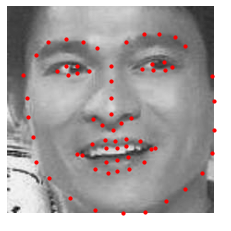

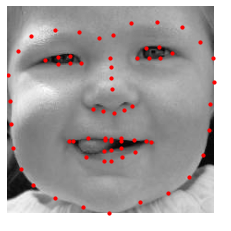

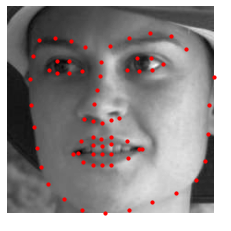

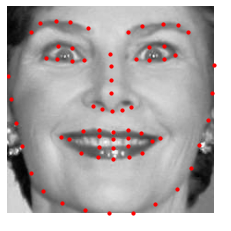

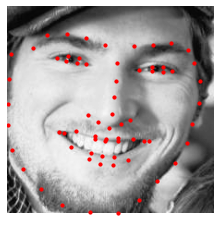

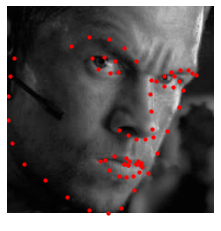

In [132]:
for i_batch, sample_batched in enumerate(val_large_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())
    
    # observe 4th batch and stop.
    show_landmarks_batch(sample_batched)
    break

## Train CNN

In [133]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [134]:
class NeuralNet3(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.model_name = 'resnet18'
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 68 * 2)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.to(device)


    def forward(self, x):
        x = self.model.forward(x)
        return x

    def run_training(self, train_loader, val_loader, lr=1e-3, num_epochs=25):

      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
      training_loss = []
      validation_loss = []

      print("***START TRAINING***")
      for epoch in range(num_epochs):
        epoch_loss = 0
        running_loss = 0
        self.model.train()
        for i, data in enumerate(train_loader, 0):
          image, landm = data['image'].float().cuda(), data['landmarks'].float().cuda()
          optimizer.zero_grad()

          outputs = self.model(image)
          outputs = outputs.unsqueeze(1)
          if(image.shape[1] != 1 or image.shape[2] != 224 or image.shape[3] != 224):
            print("jump image", image.shape)
            continue
          if(landm.shape[1] != 68 or landm.shape[2] != 2):
            print("jump landmark", landm.shape)
            continue
          loss = loss_function(outputs, landm.reshape(landm.shape[0], 1, -1))
          loss.backward()
          optimizer.step()
      
          epoch_loss += loss.item()
          running_loss += loss.item()

          if i % 8 == 7:    # print every 8 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 8 / BATCH_SIZE))
            running_loss = 0.0


        print(epoch+1, epoch_loss / len(train_loader) / BATCH_SIZE)
        val_loss = self.evaluate(val_loader)
        training_loss.append(epoch_loss /len(train_loader))
        validation_loss.append(val_loss)

      print("FINISHED TRAINING")
      return training_loss, validation_loss



    def evaluate(self, val_loader):
      # self.model.eval()
      val_loss = 0
      loss_function = nn.MSELoss()
      for i, data in enumerate(val_loader, 0):
        image, landm = data['image'].float().cuda(), data['landmarks'].float().cuda()
        with torch.no_grad():
          outputs = self.model(image).unsqueeze(1)
        if(landm.shape[1] != 68 or landm.shape[2] != 2):
          print(landm.shape)
          continue
        loss = loss_function(outputs, landm.reshape(landm.shape[0], 1, -1))
        val_loss += loss.item()

      print("eval loss: ", val_loss / len(val_loader)/ BATCH_SIZE) 
      return val_loss / len(val_loader)

In [135]:
resnet = NeuralNet3(device)
# print(resnet)

In [136]:
NUM_EPOCH = 20
LEARNING_RATE = 1e-2
training_loss, validation_loss = resnet.run_training(train_large_dataloader, val_large_dataloader,LEARNING_RATE, NUM_EPOCH)

***START TRAINING***
[1,     8] loss: 95.381
[1,    16] loss: 31.885
[1,    24] loss: 7.508
[1,    32] loss: 3.700
[1,    40] loss: 2.514
1 26.96297748315902
eval loss:  2.249906973405318
[2,     8] loss: 2.178
[2,    16] loss: 1.936
[2,    24] loss: 1.953
[2,    32] loss: 1.832
[2,    40] loss: 1.831
2 1.9378393122128077
eval loss:  1.7991755442185835
[3,     8] loss: 1.791
[3,    16] loss: 1.810
[3,    24] loss: 1.768
[3,    32] loss: 1.785
[3,    40] loss: 1.725
3 1.7795355802490598
eval loss:  1.7235294688831677
[4,     8] loss: 1.687
[4,    16] loss: 1.690
[4,    24] loss: 1.646
[4,    32] loss: 1.662
[4,    40] loss: 1.683
4 1.6705517683710371
eval loss:  1.5727405873211948
[5,     8] loss: 1.469
[5,    16] loss: 1.487
[5,    24] loss: 1.398
[5,    32] loss: 1.349
[5,    40] loss: 1.327
5 1.396905589671362
eval loss:  1.2390941273082385
[6,     8] loss: 1.219
[6,    16] loss: 1.176
[6,    24] loss: 1.061
[6,    32] loss: 1.091
[6,    40] loss: 1.116
6 1.1229212894326164
eval loss

In [139]:
torch.save(resnet.state_dict(), "state_dict_model2.pt")

In [ ]:
model = NeuralNet3(device)
model.load_state_dict(torch.load("state_dict_model2.pt"))
model.eval()

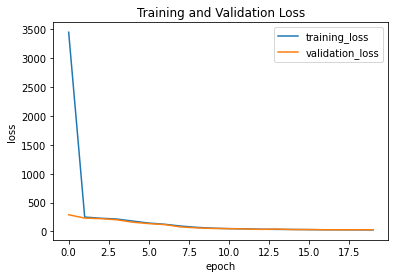

In [137]:
plt.plot(training_loss, label="training_loss")
plt.plot(validation_loss, label="validation_loss")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();
plt.savefig("training_resnet_plot.jpg")

## Testing on test set

In [138]:
class IbugDataset2(Dataset):

  def __init__(self, img_filenames, bbox, transform=None):

    self.transform = transform
    self.imgs_name = img_filenames
    self.bbox = bbox

  def __len__(self):
    return len(self.imgs_name)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    
    image = color.rgb2gray(skio.imread(self.imgs_name[idx]))
    x, y, w, h = self.bbox[idx]
    x, y, w, h = int(max(0, 0.9*x)), int(max(0, 0.9 * y)), int(1.1*w), int(1.1*h)
    # landmark[:,0] -= x
    # landmark[:,1] -= y
    # landmark[:,0] = landmark[:,0] / w * 224
    # landmark[:,1] = landmark[:,1] / h * 224

    image = image[y:y+h, x:x+w]

    sample = {'image': image, "shape": np.array([x,y,w,h])}
    if self.transform:
        sample['image'] = self.transform(sample['image'].astype(np.float32))

    return sample

In [140]:
#Evaluate on test set
test_path = 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_parsed.xml'
test_dir = 'ibug_300W_large_face_landmark_dataset'
test_bboxes, _, test_img_filenames = preprocess(test_path, test_dir, False)

In [146]:
test_large_dataset = IbugDataset2(test_img_filenames, test_bboxes, transform=transforms.Compose(
                  [transforms.ToPILImage(), 
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.5], std=[0.5])]))
test_large_dataloader = DataLoader(test_large_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

torch.Size([128, 136])
torch.Size([128, 136])
torch.Size([128, 136])
torch.Size([128, 136])
torch.Size([128, 136])


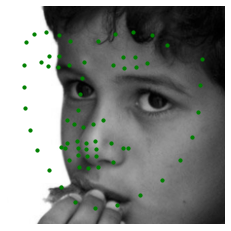

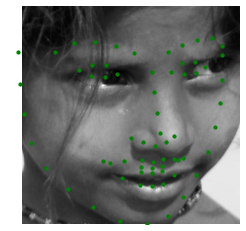

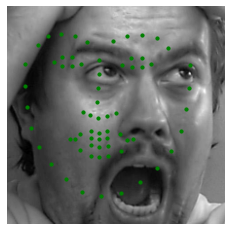

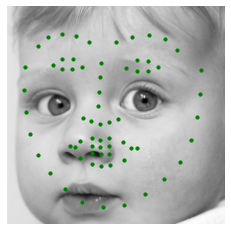

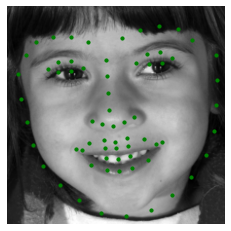

In [147]:
for i, data in enumerate(test_large_dataloader, 0):
  image = data['image'].float().cuda()
  outputs = resnet.model(image)
  print(outputs.shape)
  outputs = outputs.reshape(outputs.shape[0], 68, -1).cpu()
  plt.figure()
  plt.imshow(image[0,:,:].squeeze(0).cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
  plt.scatter(outputs.detach().numpy()[0][:,0],outputs.detach().numpy()[0][:,1], s=40, marker='.', c='g')
  plt.savefig("testing_resnet_" + str(i) + ".jpg")
  if i == 4:
    break

In [148]:
#Kaggle Predictions
all_outputs = []
for i, data in enumerate(test_large_dataloader, 0):
  image, shape = data['image'].float().cuda(), data['shape'] 
  outputs = resnet.model(image).cpu().unsqueeze(1)
  outputs = outputs.reshape(outputs.shape[0],68,2)
  for j in range(outputs.shape[0]):
    outputs[j,:,0] = outputs[j,:,0] / 224 * shape[j,2]
    outputs[j,:,1] = outputs[j,:,1] / 224 * shape[j,3]
    outputs[j,:,0] += shape[j,0]
    outputs[j,:,1] += shape[j,1]
  flat_outputs = outputs.reshape(1, -1).tolist()
  all_outputs.extend(flat_outputs)


In [149]:
all_out = [item for sublist in all_outputs for item in sublist]
df = pd.DataFrame({'Id': np.arange(len(all_out)),
                   'Predicted': all_out})
df.to_csv("result.csv", index=False)

In [174]:
#Predict on Personal Images
names = ["1.jpg", "2.jpg", "3.jpg"]
boxes = [[158, 82, 107, 103], [198, 50, 140, 144], [198, 88, 179,174]]

In [175]:
personal_dataset = IbugDataset2(names, boxes, transform=transforms.Compose(
                  [transforms.ToPILImage(), 
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.5], std=[0.5])]))
personal_dataloader = DataLoader(personal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

torch.Size([3, 136])


<Figure size 432x288 with 0 Axes>

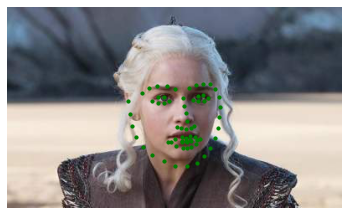

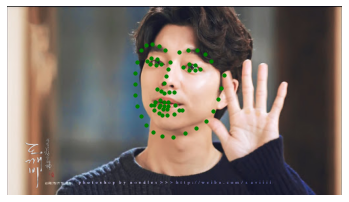

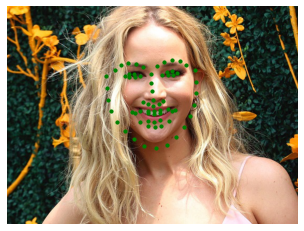

In [176]:
for i, data in enumerate(personal_dataloader, 0):
  image, shape = data['image'].float().cuda(), data['shape']
  outputs = resnet.model(image)
  print(outputs.shape)
  outputs = outputs.reshape(outputs.shape[0], 68, -1).cpu()
  plt.figure()
  for j in range(image.shape[0]):
    outputs[j,:,0] = outputs[j,:,0] / 224 * shape[j,2]
    outputs[j,:,1] = outputs[j,:,1] / 224 * shape[j,3]
    outputs[j,:,0] += shape[j,0]
    outputs[j,:,1] += shape[j,1]

    plt.figure()
    # plt.imshow(image[j,:,:].squeeze(0).cpu().detach().numpy(), cmap='gray')
    plt.imshow(skio.imread(str(j + 1) + ".jpg"))
    plt.axis('off')
    plt.scatter(outputs.detach().numpy()[j][:,0],outputs.detach().numpy()[j][:,1], s=40, marker='.', c='g')
    plt.savefig("personal_resnet" + str(j) + ".jpg")